In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as transformers

import numpy as np
import pandas as pd
import seaborn as sns

from transformers import CLIPModel
from transformers import AutoProcessor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict

/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from EDFunctions import *

In [3]:
images, targets = get_ciafar10_data()


/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
image_embeddings = np.load('2d_embeddings.npy')

In [ ]:
def get_class_embeddings(embeddings, targets, label):
    #print(f'embeddings shape {embeddings.shape}')
    targets = np.array(targets)
    targets = np.expand_dims(targets, 1)

    all_indexes = np.array(range(0, embeddings.shape[0]))
    all_indexes = np.expand_dims(all_indexes, 1)

    full_data = np.append(embeddings, all_indexes, axis=1) 
    #print(f'full_data shape: {full_data.shape}')
    #print(f'all_indexes shape: {all_indexes.shape}')
    full_data = np.append(full_data, targets, axis=1) 

    #print(f'full_data shape: {full_data.shape}')

    class_data = full_data[ full_data[:,-1] == label ]
    true_indexes = class_data[:,-2].astype(int)
    #true_indexes = true_indexes[:]
    #print(true_indexes)
    class_data = class_data[:,:-2]



    return class_data, true_indexes


#expects data to be in shape (m x d)
def fit_distribution(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    diag = np.diagonal(covar)
    sd = np.sqrt(diag)
    new_dist = (class_data - mu)/sd
    return mu, covar, new_dist


import scipy.stats as st
import scipy.linalg
def get_points_outside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf(percentage/2))
    #print(radius)

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms > radius]

def get_points_inside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf((1 - percentage)/2))
    #print(f'radius {radius}')

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms < radius ]
    

def get_points(dist, percentage=0.5, where='inside'):
    if (where == 'inside'):
        radius = np.abs(st.norm.ppf((1 - percentage)/2))

        norms = np.linalg.norm(dist, axis=1)
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms < radius ]

    elif (where == 'outside'):
        radius = np.abs(st.norm.ppf(percentage/2))

        norms = np.linalg.norm(dist, axis=1)
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms > radius]

    else: 
        raise Exception(f'{where} is not a valid argument')


def fit_distribution_2(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    L = np.linalg.cholesky(covar)
    print(f'cholesky: {L}')

    normalized_data = np.matmul(np.linalg.inv(L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    return normalized_mean, normalized_cov, normalized_data


# idea behind this code comes from 
# https://math.stackexchange.com/questions/1652545/multivariate-normal-value-standardization
from sklearn.preprocessing import power_transform
def fit_distribution_3(data_points, transform=True):
    if (transform):
        data_points = power_transform(data_points)

    mu = np.mean(data_points, axis=0)
    sigma = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    sigma_inv_sqrt = scipy.linalg.sqrtm(np.linalg.inv(sigma))
    L = sigma_inv_sqrt
    #print(f'simga^(-1/2): {L}')

    normalized_data = np.matmul((L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    return normalized_mean, normalized_cov, normalized_data



# returns a list of list of indexes
# each entry in the list contains all the indexes used in that class for the partition
def get_all_partitions(embeddings, targets, labels, percentage, where, transform=False):
    partitions = []
    for l in labels:
        class_data, true_indexes = get_class_embeddings(embeddings, targets, l)
        num_class_points = class_data.shape[0]
        print(f'true_indexes for class {l}: ')
        print(true_indexes.shape)
        print(true_indexes)

        _, _, standardized_data = fit_distribution_3(class_data, transform)

        points = get_points(standardized_data, percentage, where)
        num_points_selected = points.shape[0]

        print(f'{num_points_selected/num_class_points}% points selected for class {l}')

        
        selected_indexes = []
        #print(len(points))
        #print(selected_indexes)
        #print(f'type: {type(true_indexes[points])}')
        #print(f'points type: {type(points)}')
        #print(f'points shape{points.shape}')

        points = points.astype(int)
        true_indexes = true_indexes.astype(int)

        for x in points:
            selected_indexes.append(true_indexes[x])

        selected_indexes = selected_indexes
        #print((selected_indexes))
        partitions.append(selected_indexes)
    
    print('done')

    return partitions

        


#class_data, true_indexes = get_class_embeddings(image_embeddings, targets, 0)
#print(f'cd shape: {class_data.shape}')
#print(true_indexes)
#mu, covar, new_d = fit_distribution_3(class_data, True)

#point_indexes = get_points_inside(new_d, 0.50)
#print(point_indexes.shape[0])

#plot_batch_elements(new_d, point_indexes)
#plt.show()


#class_data, true_indexes = get_class_embeddings(image_embeddings, targets, 0)
#mu, covar, new_d = fit_distribution_3(class_data, True)

#point_indexes = get_points_inside(new_d, 0.50)
#print(point_indexes.shape)

#plot_batch_elements(new_d, point_indexes)
#plt.show()

#class_data = get_class_embeddings(image_embeddings, targets, 3)
#mu, covar, new_d = fit_distribution_2(class_data)

#point_indexes = get_points_inside(new_d, 0.70)
#print(point_indexes.shape)

#plot_batch_elements(new_d, point_indexes)
#plt.show()


true_indexes for class 0: 
(6000,)
[    3    10    21    27    44    52    74    90    97    98   111   116
   125   153   154   169   179   180   189   192   206   215   235   237
   244   255   257   258   264   269   276   281   284   287   297   298
   313   315   338   352   359   376   378   382   398   406   416   422
   423   428   447   473   477   489   491   496   499   522   524   526
   527   531   539   560   581   584   602   638   642   667   675   678
   689   742   763   767   774   778   785   791   814   822   841   847
   854   857   864   868   883   885   886   888   912   914   919   928
   929   944   946   956   975   982   989  1001  1010  1018  1022  1023
  1026  1027  1036  1052  1067  1072  1076  1077  1078  1090  1093  1103
  1109  1137  1152  1161  1165  1183  1188  1189  1197  1203  1210  1237
  1241  1266  1295  1310  1319  1322  1323  1343  1365  1397  1409  1434
  1440  1446  1461  1463  1485  1514  1555  1568  1573  1574  1579  1596
  1617  1646  16

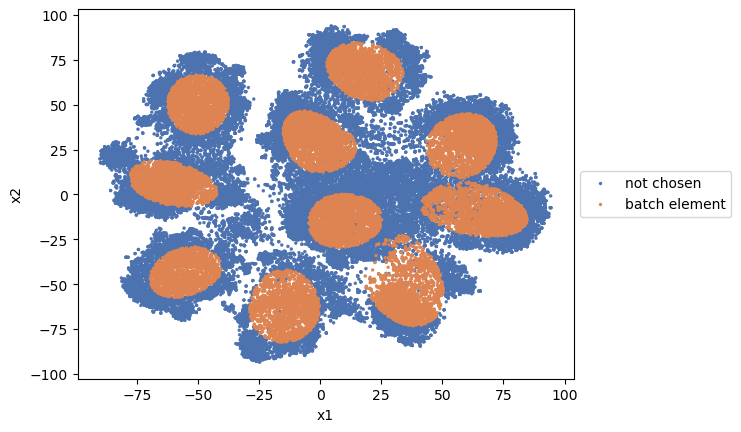

In [ ]:
labels = np.array(range(0, 10))

indexes = get_all_partitions(image_embeddings, targets, labels, 0.73, "inside", True)
all_indexes = []
for l in indexes:
    all_indexes.extend(l)

#print(type(all_indexes[0][0]))

print('here')
print((all_indexes))

fig = plot_batch_elements(image_embeddings, all_indexes, tick_size=5)

In [89]:
labels = np.array(range(0, 10))

clip_embeddings = np.load('cifar10_clip_embeddings.npy')

indexes = get_all_partitions(clip_embeddings, targets, labels, 0.73, "inside", True)
all_indexes = []
for l in indexes:
    all_indexes.extend(l)

#print(type(all_indexes[0][0]))

print('here')
print((all_indexes))

fig = plot_batch_elements(clip_embeddings, all_indexes, tick_size=5)

true_indexes for class 0: 
(6000,)
[    3    10    21    27    44    52    74    90    97    98   111   116
   125   153   154   169   179   180   189   192   206   215   235   237
   244   255   257   258   264   269   276   281   284   287   297   298
   313   315   338   352   359   376   378   382   398   406   416   422
   423   428   447   473   477   489   491   496   499   522   524   526
   527   531   539   560   581   584   602   638   642   667   675   678
   689   742   763   767   774   778   785   791   814   822   841   847
   854   857   864   868   883   885   886   888   912   914   919   928
   929   944   946   956   975   982   989  1001  1010  1018  1022  1023
  1026  1027  1036  1052  1067  1072  1076  1077  1078  1090  1093  1103
  1109  1137  1152  1161  1165  1183  1188  1189  1197  1203  1210  1237
  1241  1266  1295  1310  1319  1322  1323  1343  1365  1397  1409  1434
  1440  1446  1461  1463  1485  1514  1555  1568  1573  1574  1579  1596
  1617  1646  16

ValueError: Shape of passed values is (60000, 512), indices imply (60000, 2)

In [7]:
import sys
import numpy
numpy.set_printoptions(threshold = sys.maxsize)
#numpy.set_printoptions(threshold= False)

In [8]:
image_embeddings_slice = image_embeddings[:1000][:][:][:]

#distances = calc_distances(image_embeddings_slice)
#sorted_distances = sort_distances(distances)

batch_size = 100

#batch_indexes = generate_indexes_proportional(image_embeddings_slice, sorted_distances, batch_size, seed=None)
#batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size)#, seed=1)
batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size, power=10, seed=1)

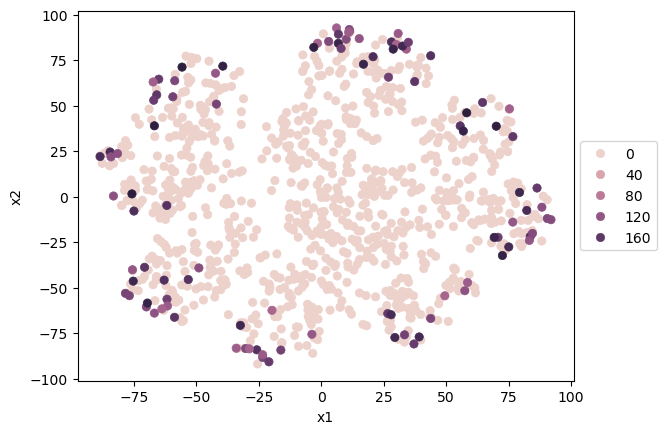

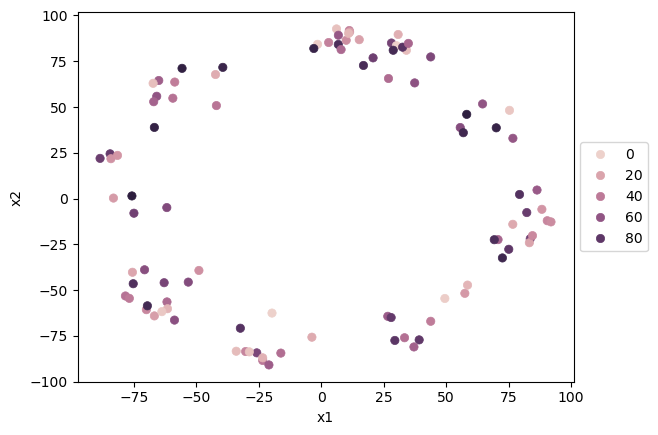

<class 'matplotlib.figure.Figure'>


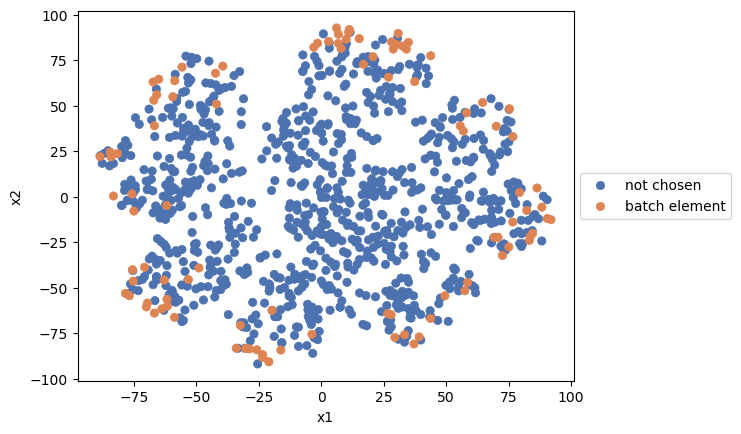

In [9]:
fig1 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='inclusive')
#plt.close()
plt.show()
fig2 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='exclusive')
#plt.close()
plt.show()
fig3 = plot_batch_elements(image_embeddings_slice,batch_indexes)
print(type(fig2))
plt.show()

10


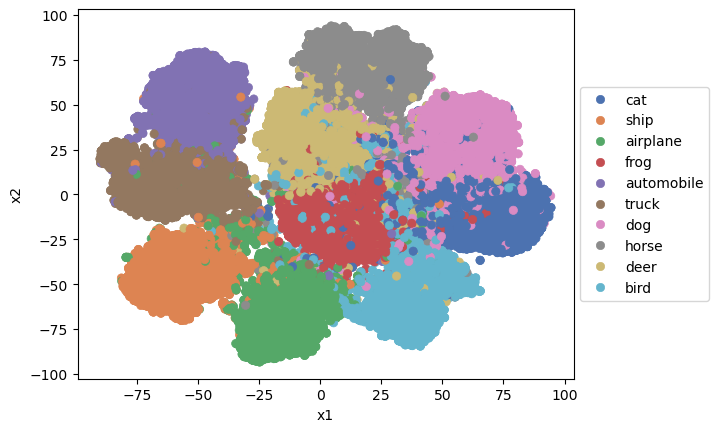

In [10]:
b = plot_classes_2d(image_embeddings, targets)
